In [1]:
import os
import shutil


def split_dataset(paths, orgin_dir, name):
    train_ratio = 0.6
    validation_ratio = 0.2
    test_ratio = 0.2
    size = len(paths)
    train_val_boundary = int(size * train_ratio)
    val_test_boundary = int(-1 * (size * test_ratio))
    train_dir = "dataset/Train"
    val_dir = "dataset/Validation"
    test_dir = "dataset/Test"
    os.makedirs(os.path.join(train_dir, name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, name), exist_ok=True)
    for path in paths[:train_val_boundary]:
        shutil.copy(os.path.join(orgin_dir, path), os.path.join(train_dir, name))
    for path in paths[train_val_boundary:val_test_boundary]:
        shutil.copy(os.path.join(orgin_dir, path), os.path.join(val_dir, name))
    for path in paths[val_test_boundary:]:
        shutil.copy(os.path.join(orgin_dir, path), os.path.join(test_dir, name))


boot_paths = os.listdir("dataset/Shoe vs Sandal vs Boot Dataset/Boot")
shoe_paths = os.listdir("dataset/Shoe vs Sandal vs Boot Dataset/Shoe")
sandal_paths = os.listdir("dataset/Shoe vs Sandal vs Boot Dataset/Sandal")

split_dataset(boot_paths, "dataset/Shoe vs Sandal vs Boot Dataset/Boot", "Boot")
split_dataset(shoe_paths, "dataset/Shoe vs Sandal vs Boot Dataset/Shoe", "Shoe")
split_dataset(sandal_paths, "dataset/Shoe vs Sandal vs Boot Dataset/Sandal", "Sandal")


In [2]:
from keras import utils


IMAGE_SIZE = (256, 256)


train_data = utils.image_dataset_from_directory(
    "dataset/Train",
    image_size=IMAGE_SIZE,
    seed=1998,
)
val_data = utils.image_dataset_from_directory(
    "dataset/Validation",
    image_size=IMAGE_SIZE,
    seed=1998,
)
test_data = utils.image_dataset_from_directory(
    "dataset/Test",
    image_size=IMAGE_SIZE,
    seed=1998,
)
train_data.class_names


2022-10-31 12:43:06.162543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 12:43:06.354040: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 12:43:07.029922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-31 12:43:07.030011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Found 9000 files belonging to 3 classes.


2022-10-31 12:43:09.275939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-31 12:43:09.314094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-31 12:43:09.314781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-31 12:43:09.315605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Found 3000 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.


['Boot', 'Sandal', 'Shoe']

In [3]:
import tensorflow as tf

def get_resnetv2(image_size):
    resnetv2 = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_shape=(*image_size, 3)
    )
    resnetv2.trainable = False
    resnetv2.get_layer("conv5_block3_1_conv").trainable = True
    resnetv2.get_layer("conv5_block3_2_conv").trainable = True
    resnetv2.get_layer("conv5_block3_3_conv").trainable = True
    return resnetv2

get_resnetv2(IMAGE_SIZE).summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [4]:

def get_pretrained_model(image_size, resnetv2):
    model_in = tf.keras.layers.Input((*image_size, 3))
    # Data augmentation stage
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(model_in)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
    x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)(x)
    # Extraction stage
    x = tf.keras.applications.resnet_v2.preprocess_input(x)
    x = resnetv2(x)
    # Classification stage
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(2048, activation="relu", kernel_regularizer="l2")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(2048, activation="relu", kernel_regularizer="l2")(x)
    model_out = tf.keras.layers.Dense(3, activation="softmax")(
        x
    )
    # Return model
    return tf.keras.Model(inputs=[model_in], outputs=[model_out])


pretrained_model = get_pretrained_model(IMAGE_SIZE, get_resnetv2(IMAGE_SIZE))
pretrained_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0     

In [5]:
import numpy as np


class CustomSparseMAE(tf.keras.metrics.Metric):
    def __init__(self, name="custom_mae", **kwargs):
        super().__init__(name, dtype=None, **kwargs)
        self.data_len = self.add_weight("data_len", initializer="zero")
        self.mae = self.add_weight("mae", initializer="zero")

    def update_state(self, y_true, y_pred, sample_weight=None):
        batch_size = tf.shape(y_pred)[0]
        num_classes = tf.shape(y_pred)[-1]
        batch_data_len = tf.cast(batch_size * num_classes, tf.float32)
        self.data_len.assign_add(batch_data_len)

        one_hot_y_true = tf.one_hot(y_true, num_classes)
        reshaped_y_pred = tf.reshape(y_pred, (-1, 1, num_classes))
        batch_mae = tf.reduce_sum(
            tf.abs(tf.cast(one_hot_y_true, tf.float32) - tf.cast(y_pred, tf.float32)),
        )
        self.mae.assign_add(batch_mae)

    def result(self):
        return self.mae / self.data_len


In [6]:
pretrained_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), CustomSparseMAE()],
)


In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy", patience=5, restore_best_weights=True
)


In [8]:
prepretrained_model_history =pretrained_model.fit(
    train_data,
    batch_size=32,
    epochs=100,
    validation_data=val_data,
    callbacks=[early_stopping],
)


Epoch 1/100


2022-10-31 12:44:03.057142: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB (rounded to 1073741824)requested by op RMSprop/RMSprop/update/mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-10-31 12:44:03.057224: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-10-31 12:44:03.057236: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 118, Chunks in use: 118. 29.5KiB allocated for chunks. 29.5KiB in use in bin. 8.2KiB client-requested in use in bin.
2022-10-31 12:44:03.057242: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 32, Chunks in use: 32. 16.2KiB allocated for chunks. 16.2KiB in use in bin. 16.0KiB client-requested in use in bin.
2022-10-3

ResourceExhaustedError: Graph execution error:

Detected at node 'RMSprop/RMSprop/update/mul' defined at (most recent call last):
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2473/1686102532.py", line 1, in <cell line: 1>
      prepretrained_model_history =pretrained_model.fit(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 915, in __call__
      result = self._call(*args, **kwds)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 980, in _call
      return self._stateless_fn(*args, **kwds)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 2495, in __call__
      filtered_flat_args) = self._maybe_define_function(args, kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 2760, in _maybe_define_function
      graph_function = self._create_graph_function(args, kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 2670, in _create_graph_function
      func_graph_module.func_graph_from_py_func(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 1247, in func_graph_from_py_func
      func_outputs = python_func(*func_args, **func_kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 677, in wrapped_fn
      out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 1222, in autograph_handler
      return autograph.converted_call(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 1315, in run
      return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2891, in call_for_each_replica
      return self._call_for_each_replica(fn, args, kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3692, in _call_for_each_replica
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/engine/training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 579, in minimize
      return self.apply_gradients(grads_and_vars, name=name)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 738, in apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/merge_call_interim.py", line 51, in maybe_merge_call
      return fn(strategy, *args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 797, in _distributed_apply
      update_op = distribution.extended.update(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2635, in update
      return self._replica_ctx_update(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2514, in _replica_ctx_update
      return replica_context.merge_call(merge_fn, args=args, kwargs=kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3106, in merge_call
      return self._merge_call(merge_fn, args, kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3113, in _merge_call
      return merge_fn(self._strategy, *args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2512, in merge_fn
      return self.update(var, fn, merged_args, merged_kwargs, group=group)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2633, in update
      return self._update(var, fn, args, kwargs, group)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3706, in _update
      return self._update_non_slot(var, fn, (var,) + tuple(args), kwargs, group)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3712, in _update_non_slot
      result = fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 776, in apply_grad_to_update_var
      update_op = self._resource_apply_dense(grad, var, **apply_kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py", line 224, in _resource_apply_dense
      rms_t = coefficients["rho"] * rms + coefficients[
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 1407, in binary_op_wrapper
      return func(x, y, name=name)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 1767, in _mul_dispatch
      return multiply(x, y, name=name)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1176, in op_dispatch_handler
      return dispatch_target(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 529, in multiply
      return gen_math_ops.mul(x, y, name)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py", line 6589, in mul
      _, _, _op, _outputs = _op_def_library._apply_op_helper(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 797, in _apply_op_helper
      op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 735, in _create_op_internal
      return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 3800, in _create_op_internal
      ret = Operation(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 2108, in __init__
      c_op = _create_c_op(g, node_def, inputs, control_input_ops, op_def=op_def)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1974, in _create_c_op
      tf_stack.extract_stack_for_op(c_op, stacklevel=3)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/tf_stack.py", line 180, in extract_stack_for_op
      _tf_stack.extract_stack_for_op(
Node: 'RMSprop/RMSprop/update/mul'
Detected at node 'RMSprop/RMSprop/update/mul' defined at (most recent call last):
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2473/1686102532.py", line 1, in <cell line: 1>
      prepretrained_model_history =pretrained_model.fit(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 915, in __call__
      result = self._call(*args, **kwds)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 980, in _call
      return self._stateless_fn(*args, **kwds)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 2495, in __call__
      filtered_flat_args) = self._maybe_define_function(args, kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 2760, in _maybe_define_function
      graph_function = self._create_graph_function(args, kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 2670, in _create_graph_function
      func_graph_module.func_graph_from_py_func(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 1247, in func_graph_from_py_func
      func_outputs = python_func(*func_args, **func_kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 677, in wrapped_fn
      out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 1222, in autograph_handler
      return autograph.converted_call(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 1315, in run
      return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2891, in call_for_each_replica
      return self._call_for_each_replica(fn, args, kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3692, in _call_for_each_replica
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/engine/training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 579, in minimize
      return self.apply_gradients(grads_and_vars, name=name)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 738, in apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/merge_call_interim.py", line 51, in maybe_merge_call
      return fn(strategy, *args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 797, in _distributed_apply
      update_op = distribution.extended.update(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2635, in update
      return self._replica_ctx_update(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2514, in _replica_ctx_update
      return replica_context.merge_call(merge_fn, args=args, kwargs=kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3106, in merge_call
      return self._merge_call(merge_fn, args, kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3113, in _merge_call
      return merge_fn(self._strategy, *args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2512, in merge_fn
      return self.update(var, fn, merged_args, merged_kwargs, group=group)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2633, in update
      return self._update(var, fn, args, kwargs, group)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3706, in _update
      return self._update_non_slot(var, fn, (var,) + tuple(args), kwargs, group)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3712, in _update_non_slot
      result = fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 776, in apply_grad_to_update_var
      update_op = self._resource_apply_dense(grad, var, **apply_kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py", line 224, in _resource_apply_dense
      rms_t = coefficients["rho"] * rms + coefficients[
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 1407, in binary_op_wrapper
      return func(x, y, name=name)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 1767, in _mul_dispatch
      return multiply(x, y, name=name)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1176, in op_dispatch_handler
      return dispatch_target(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 529, in multiply
      return gen_math_ops.mul(x, y, name)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py", line 6589, in mul
      _, _, _op, _outputs = _op_def_library._apply_op_helper(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 797, in _apply_op_helper
      op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 735, in _create_op_internal
      return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 3800, in _create_op_internal
      ret = Operation(
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 2108, in __init__
      c_op = _create_c_op(g, node_def, inputs, control_input_ops, op_def=op_def)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1974, in _create_c_op
      tf_stack.extract_stack_for_op(c_op, stacklevel=3)
    File "/home/minhyuk/miniconda3/envs/keras/lib/python3.9/site-packages/tensorflow/python/util/tf_stack.py", line 180, in extract_stack_for_op
      _tf_stack.extract_stack_for_op(
Node: 'RMSprop/RMSprop/update/mul'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  failed to allocate memory
	 [[{{node RMSprop/RMSprop/update/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[Func/model/random_zoom/loop_body/stateful_uniform/Bitcast/pfor/while/body/_290/input/_663/_170]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  failed to allocate memory
	 [[{{node RMSprop/RMSprop/update/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_16705]

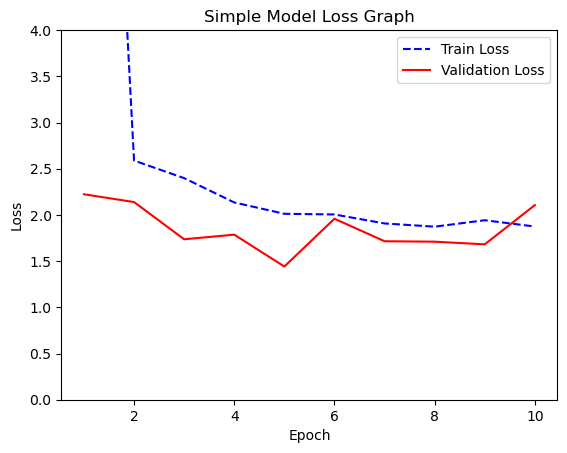

In [ ]:
import matplotlib.pyplot as plt
epoch_range = range(1, len(prepretrained_model_history.history["loss"]) + 1)
plt.plot(epoch_range, prepretrained_model_history.history["loss"], "b--", label="Train Loss")
plt.plot(epoch_range, prepretrained_model_history.history["val_loss"], "r", label="Validation Loss")
plt.ylim(0, 4)
plt.title("Simple Model Loss Graph")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

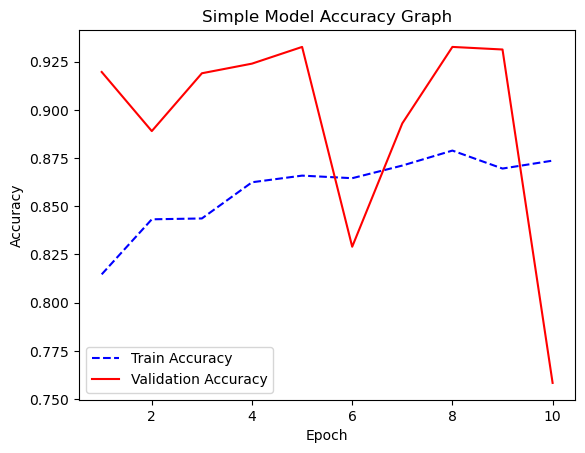

In [ ]:
import matplotlib.pyplot as plt
epoch_range = range(1, len(prepretrained_model_history.history["sparse_categorical_accuracy"]) + 1)
plt.plot(epoch_range, prepretrained_model_history.history["sparse_categorical_accuracy"], "b--", label="Train Accuracy")
plt.plot(epoch_range, prepretrained_model_history.history["val_sparse_categorical_accuracy"], "r", label="Validation Accuracy")
plt.title("Simple Model Accuracy Graph")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

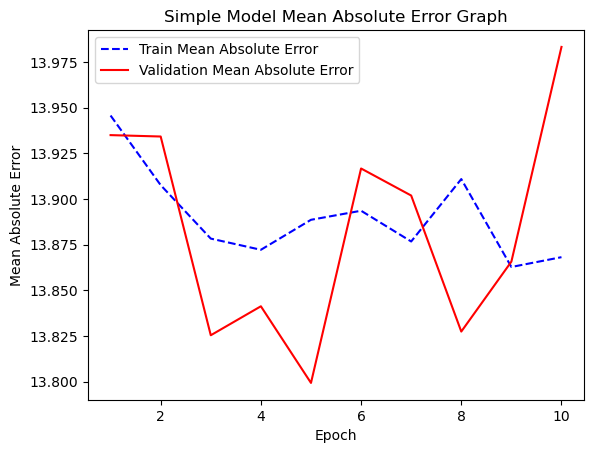

In [ ]:
import matplotlib.pyplot as plt
epoch_range = range(1, len(prepretrained_model_history.history["custom_mae"]) + 1)
plt.plot(epoch_range, prepretrained_model_history.history["custom_mae"], "b--", label="Train Mean Absolute Error")
plt.plot(epoch_range, prepretrained_model_history.history["val_custom_mae"], "r", label="Validation Mean Absolute Error")
plt.title("Simple Model Mean Absolute Error Graph")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.show()

In [ ]:
test_scores = pretrained_model.evaluate(test_data, return_dict=True)
test_scores

94/94 [==============================] - 6s 63ms/step - loss: 1.4380 - sparse_categorical_accuracy: 0.9323 - custom_mae: 13.8875


{'loss': 1.4380024671554565,
 'sparse_categorical_accuracy': 0.9323333501815796,
 'custom_mae': 13.887491226196289}